# CNN Cancer Detection using Tissue Images

In [2]:
import os
import time

In [3]:
import cv2
from PIL import Image

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
import tensorflow as tf
import tensorflow_io as tfio
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.utils import resample

## Introduction

With AI-assisted technology, the accuracy of cancer diagnosis could be substantially improved. As a revolutionary breakthrough in the heallthcare industry, it is expected that more AI in medical applications will gradually be more prevalent and affordable.Claiming AI plays a core role in improving human life expectancy would not be an overstatement since cancer metastasis is among the top causes of human death.  In light of promising blueprint of AI-assisted diagnosis in a foreseeable future, this study aims to create a Convolution Neural Network (CNN) model to classify tumor images and benign images extracted from histopathologic tissues.

## Data Understanding

## Data Inspection

In [7]:
label_data = pd.read_csv('../input/histopathologic-cancer-detection/train_labels.csv')

In [8]:
len_train=len(label_data)

In [9]:
label_count = label_data['label'].value_counts()
label_count

label
0    130908
1     89117
Name: count, dtype: int64

In [10]:
test_data_path = '../input/histopathologic-cancer-detection/test'

In [11]:
testfiles = [os.path.join(test_data_path, testfile) for testfile in os.listdir(test_data_path)]
len(testfiles)

57458

In [12]:
test_filenames = [os.path.join(test_data_path, filename) for filename in os.listdir(test_data_path)]
len_test = len(test_filenames)
len_test

57458

In [13]:
len_test/len_train

0.2611430519259175

In [14]:
train_data_path = '../input/histopathologic-cancer-detection/train/'

In [15]:
len_train = len(os.listdir(train_data_path))
#len_train

In [16]:
test_data_path = '../input/histopathologic-cancer-detection/test'

In [17]:
len_test = len(os.listdir(test_data_path))
len_test

57458

Checking both Train and Test Data we can see that all pictures are in .TIF which means they have a higher quality than .PNG or .JPEG. .TIF or .TIFF are used in professinal photografy world and for a investigation of cancer, those images have to have a high-end quality and that's the why those images are in .TIF

In [18]:
label_data = pd.read_csv('../input/histopathologic-cancer-detection/train_labels.csv')

In [19]:
label_data.value_counts()

id                                        label
00001b2b5609af42ab0ab276dd4cd41c3e7745b5  1        1
aafa66be401644d911bf216e6e3d3e7970f55194  1        1
aafb5b379c54b029f395eb664e052653a8d5c5db  1        1
aafbdfd08f338fa8eb59e76e4e5a026e81b1915b  0        1
aafcecc71fcc22a018c7966f629133dd6ad93ebd  1        1
                                                  ..
55b8cb133f5755df024ec0c46bc5579c9178bed1  0        1
55b8f6c58e3d6e719866cf76c0d5bc22840ad188  0        1
55b9081b80241e43db5d314e9c3327d8fc8bb68f  1        1
55b94ae30d2025a815c4729a97acdbd06f7398e4  1        1
ffffe55093358954f38bba4c35b6aa0ece86177c  0        1
Name: count, Length: 220025, dtype: int64

In [20]:
label_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


In [21]:
label_data.describe()

,label
count,220025.000000
mean,0.405031
std,0.490899
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [22]:
label_count = label_data['label'].value_counts()

In [23]:
label_count

label
0    130908
1     89117
Name: count, dtype: int64

# Label Description

In [24]:
label_data['label'].values

array([0, 1, 0, ..., 0, 0, 1])

0: no tumor tissue  
1: with tumor tissue

Text(0, 0.5, '%')

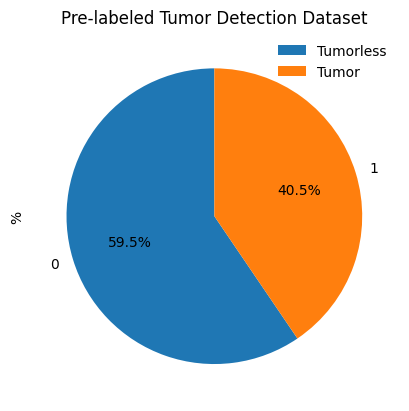

In [25]:
#label_count.index
plt.pie(label_count, labels = label_count.index, startangle=90, autopct='%1.1f%%')
#plt.pie(label_count, labels = [0,1], startangle=90, autopct='%1.1f%%')
#plt.title('Tumor Tissue')
plt.title('Pre-labeled Tumor Detection Dataset')
#plt.xlabel('0 = No Tumor, 1 = Tumor')
plt.legend(['Tumorless', 'Tumor'],loc="best",frameon=False)
#plt.ylabel('Propotion')
plt.ylabel('%')

# Images of tumorless data slightly outnumber those of tumor data. We can specify the desired train data size equally divided into tumorless and tumor data.

In [26]:
train_ratio, test_ratio = len_train/(len_test+len_train), len_test/(len_test+len_train)
print(train_ratio, test_ratio)

# Although length of the train data significantly larger than that of the test data, we would only use part of it, 40000 images, due to the limitation of CPU capability. While this decision would limit both the train accuracy and ability to predict the test data, the result is good enough to demonstrate the knowledge of deep learning.

# Train Data Balancing

In [30]:
# Get the number of samples for each class
n_class_0 = len(label_data[label_data['label'] == 0])
n_class_1 = len(label_data[label_data['label'] == 1])

# Minimum number of samples for balanced training data
n_samples = min(n_class_0, n_class_1)
print(n_samples)

n_balanced = 20000
# Shuffle the data for each class and select n_samples randomly
train_class_0 = label_data[label_data['label'] == 0].sample(n_balanced, random_state=42)
train_class_1 = label_data[label_data['label'] == 1].sample(n_balanced, random_state=42)
#print(len(train_class_0.index),len(train_class_1.index))
train_class_idxs = train_class_0.index.append(train_class_1.index)
# Combine the balanced dataframes for training
balanced_train_data = pd.concat([train_class_0, train_class_1]) # length: 2*n_balanced

89117


In [31]:
balanced_train_data['label'] = balanced_train_data['label'].astype(str)  # Convert label column to string

# Train Data Image Samples

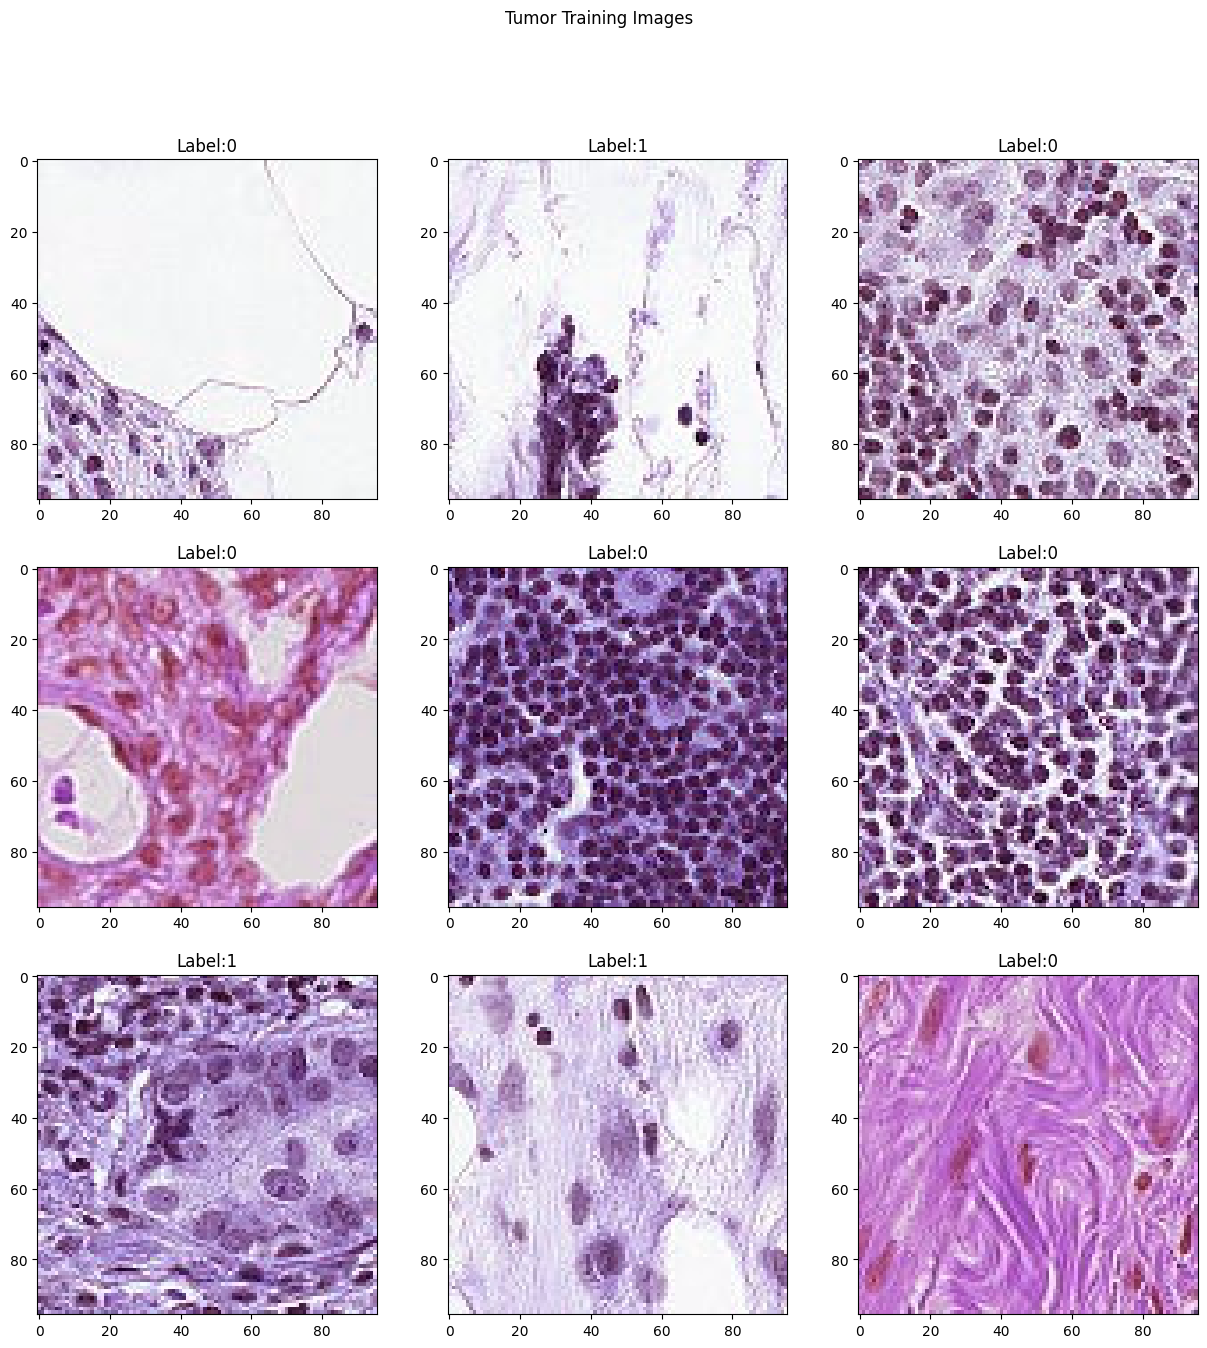

In [32]:
# define subplot grid
fig, axs = plt.subplots(nrows=3, ncols=3)
#plt.subplots_adjust(hspace=0.5)
fig.set_figheight(15)
fig.set_figwidth(15)
fig.suptitle("Tumor Training Images", fontsize=12)

# loop through tickers and axes
for i, ax in enumerate(axs.ravel()):
    # filter df for ticker and plot on specified axes
    im=cv2.imread(train_data_path + label_data['id'][i] +'.tif')
    ax.imshow(im, resample=True, cmap='gray')

    # chart formatting
    ax.set_title('Label:'+str(label_data['label'][i]), fontsize=12)
    ax.set_xlabel("")

plt.show()

## CNN Modeling

In [33]:
kernel_size = (3,3)
pool_size= (2,2)
first_layer = 32
second_layer = 64



dropout_hidden = 0.1
dropout_dense = 0.2


model = Sequential()
model.add(Conv2D(first_layer, kernel_size, activation = 'relu', input_shape = (96, 96, 3)))
model.add(Conv2D(first_layer, kernel_size, activation = 'relu'))
model.add(Conv2D(first_layer, kernel_size, activation = 'relu'))
model.add(MaxPooling2D(pool_size = pool_size)) 
model.add(Dropout(dropout_hidden))


model.add(Conv2D(second_layer, kernel_size, activation ='relu'))
model.add(Conv2D(second_layer, kernel_size, activation ='relu'))
model.add(Conv2D(second_layer, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_hidden))

model.add(Flatten())
model.add(Dense(512, activation = "relu"))
model.add(Dropout(dropout_dense))
model.add(Dense(1, activation = "sigmoid"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 94, 94, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 92, 92, 32)        9248      
                                                                 
 conv2d_2 (Conv2D)           (None, 90, 90, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 45, 45, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 45, 45, 32)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 43, 43, 64)        18496     
                                                        

# Nadam is the variation of Adam, a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments. By incorporating Nesterov momentum, Nadam is equipped with a lookahead capability to gradient updates.

In [34]:
from tensorflow.keras.optimizers import Nadam

optimizer = Nadam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [35]:
label_data['label'] = label_data['label'].astype(str)  # Convert label column to string

# The entire train data is too large to learn without assistance of GPU. Only 40000 images are extracted for training and valiidation respectively with a batches size of 128. Dropout layers were added in the CNN model to avoid overfitting.

In [36]:
# Add the .tif extension to the 'id' column for correct file referencing
label_data['id'] = label_data['id'].apply(lambda x: f"{x}.tif")

# Assume choosing 40000 train images and 5000 validation images
# split_rate = len(val_data)/len(train_data)
split_rate = 5000/40000

# Preparing data generators
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=split_rate)  # Normalize images

#batch_size = 128
batch_size = 32
train_steps = 2000*(1-split_rate) // batch_size  
val_steps = 2000*split_rate // batch_size    

print(train_steps,val_steps)


train_gen = train_datagen.flow_from_dataframe(
    dataframe=label_data.loc[train_class_idxs],
    directory=train_data_path,
    x_col='id',
    y_col='label',
    target_size=(96, 96),
    class_mode='binary',
    batch_size=batch_size,
    subset='training'
)

val_gen = train_datagen.flow_from_dataframe(
    dataframe=label_data.tail(5000),
    directory=train_data_path,
    x_col='id',
    y_col='label',
    target_size=(96, 96),
    class_mode='binary',
    batch_size=batch_size,
    subset='validation'
)

# Training the model
history = model.fit(
    train_gen,
    steps_per_epoch=train_steps,
    validation_data=val_gen,
    validation_steps=val_steps,
    epochs=15
)

54.0 7.0
Found 35000 validated image filenames belonging to 2 classes.
Found 625 validated image filenames belonging to 2 classes.
Epoch 1/15
54/54 [==============================] - 73s 1s/step - loss: 0.6476 - accuracy: 0.6215 - val_loss: 0.6538 - val_accuracy: 0.6429
Epoch 2/15
54/54 [==============================] - 69s 1s/step - loss: 0.5131 - accuracy: 0.7558 - val_loss: 0.4547 - val_accuracy: 0.8438
Epoch 3/15
54/54 [==============================] - 68s 1s/step - loss: 0.4940 - accuracy: 0.7674 - val_loss: 0.5887 - val_accuracy: 0.6920
Epoch 4/15
54/54 [==============================] - 69s 1s/step - loss: 0.4791 - accuracy: 0.7812 - val_loss: 0.4746 - val_accuracy: 0.7634
Epoch 5/15
54/54 [==============================] - 69s 1s/step - loss: 0.4884 - accuracy: 0.7778 - val_loss: 0.4647 - val_accuracy: 0.8125
Epoch 6/15
54/54 [==============================] - 69s 1s/step - loss: 0.4789 - accuracy: 0.7749 - val_loss: 0.5639 - val_accuracy: 0.7277
Epoch 7/15
54/54 [===========

In [37]:
test_ids = [filename[:-4] for filename in os.listdir(test_data_path)]
test_filenames = [os.path.join(test_data_path, filename) for filename in os.listdir(test_data_path)]
test_df = pd.DataFrame()
test_df["id"] = test_ids
test_df["filename"] = test_filenames

In [38]:
test_generator = train_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col="filename",
    y_col=None,
    target_size=(96, 96),
    color_mode="rgb",
    batch_size=batch_size,
    shuffle=False,
    class_mode=None,
    validate_filenames=False
)

Found 57458 non-validated image filenames.


In [39]:
test_probs = model.predict(test_generator)
test_labels = np.round(test_probs).astype(int).flatten()
out_df = pd.DataFrame()
out_df["id"] = test_ids
out_df["label"] = test_labels

1796/1796 [==============================] - 463s 258ms/step


In [40]:
out_df

,id,label
0,a7ea26360815d8492433b14cd8318607bcf99d9e,0
1,59d21133c845dff1ebc7a0c7cf40c145ea9e9664,0
2,5fde41ce8c6048a5c2f38eca12d6528fa312cdbb,0
3,bd953a3b1db1f7041ee95ff482594c4f46c73ed0,1
4,523fc2efd7aba53e597ab0f69cc2cbded7a6ce62,0
...,...,...
57453,7907c88a7f5f9c8ca5b2df72c1e6ff9650eea22b,0
57454,2a6fc1ed16fa94d263efab330ccbeb1906cbd421,1
57455,6bb5c0611c0ccf4713e0ccbc0e8c54bcb498ef14,1
57456,f11e7c9e77cbc1ec916a52e6b871a293ee1bb928,0


In [41]:
out_df.to_csv('/kaggle/working/submission.csv', index=False)

## Discussion and Summary

# Submission to the competition indicates an accuracy > 75%. Good for demonstration purposes. Adding more hidden layers or train images could potentially improve the accuracy.


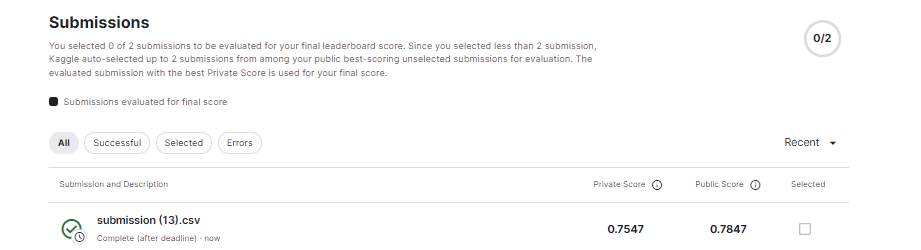

# I definitely could further optimize the CNN model and the hyperparameter settings to bring the accuracy closer to 80%. However, the work would seem tedious. To achieve the industrial level for medical applications, the accuracy should be > 90% to eliminate the hassle of medical professionals looking over thousands of images. 